In Part 1, we focused on understanding the mechanism behind gradient boosted models (GBMs). In Part 2, we'll look at the effects the parameter choices have on the models we produce and the implications of those effects.

In [1]:
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

We'll use the same two-dimensional classification dataset as before.

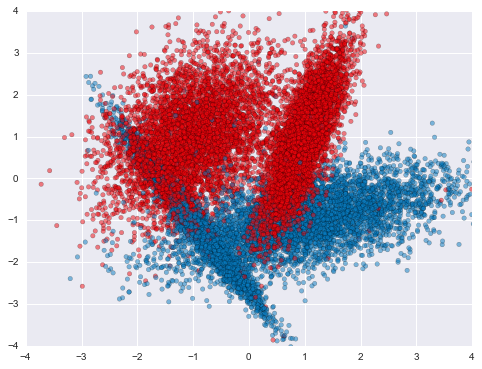

In [13]:
raw_data, raw_target = make_classification(n_samples=20000, n_features=2, n_informative=2, n_redundant=0, 
                                           n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, 
                                           flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, 
                                           shuffle=False, random_state=2)
train, test, train_t, test_t = train_test_split(raw_data, raw_target, test_size=0.2, random_state=2)

my_cm = sns.diverging_palette(h_neg=245, h_pos=12, s=99, l=50, sep=15, n=32, center='light', as_cmap=True)

plt.figure(figsize=(8,6))
plt.scatter(raw_data[:,0], raw_data[:,1], c=raw_target, alpha=0.5, cmap=my_cm)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In each case, we're going to be looking at the decision boundary produced by the models. The decision boundary represents the 

In [82]:
from sklearn.metrics import roc_auc_score
rocs = {}

def run_models(models, train=train, train_t=train_t):
    preds = {}

    for mname, m in models:
        m.fit(train, train_t)
        preds[mname] = {'train': m.predict_proba(train),  'test': m.predict_proba(test)}
    return preds

def gen_plot(mname, model, xlim=(-4, 4), ylim=(-4, 4), gridsize=0.02, marker="."):
    xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], gridsize),
                         np.arange(ylim[0], ylim[1], gridsize))
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    Z = model.predict_proba(zip(xx.ravel(), yy.ravel()))
    plt.title(mname)
    plt.pcolormesh(xx, yy, Z[:,1].reshape(xx.shape), cmap=my_cm)
    plt.scatter(raw_data[:,0], raw_data[:,1], c=raw_target, alpha=0.8, marker=marker, cmap=my_cm)

def three_plots(mname, model):
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    gen_plot("%s: full view" % mname, model)
    plt.axhspan(-2, 2, 0.125, 0.375, fill=False, lw=1.5)
    auc = "AUC: %.3f" % roc_auc_score(test_t, preds[mname]['test'][:,1])
    plt.text(-3.75, -3.75, auc, {'color': 'white', 'size': 16})
    
    plt.subplot(1,3,2)
    gen_plot("%s: detailed view" % mname, model, (-3, -1), (-2, 2), 0.005)
    plt.axhspan(-1, 0, 0.5, 0.75, fill=False, lw=1.5)
    
    plt.subplot(1,3,3)
    gen_plot("%s: extreme closeup" % mname, model, (-2, -1.5), (-1, 0), 0.00125)
    plt.show()

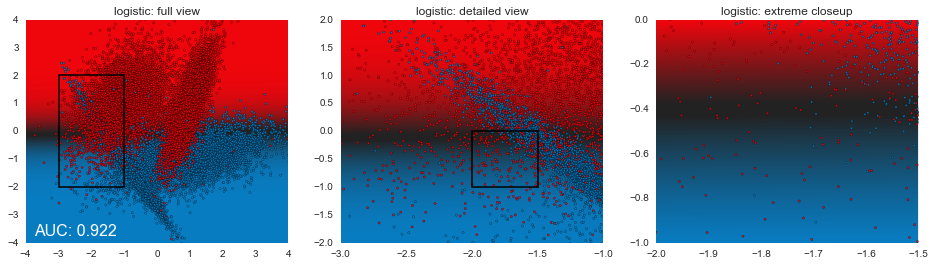

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = [('logistic', LogisticRegression(random_state=2)),]
          #('knn', KNeighborsClassifier(n_neighbors=13)),
          #('svc', SVC(tol=1, probability=True, random_state=2))]

preds = fit_models(models)
for mname, model in models:
    three_plots(mname, model)
rocs.update({mname: roc_auc_score(test_t, p['test'][:,1]) for mname, p in preds.iteritems()})

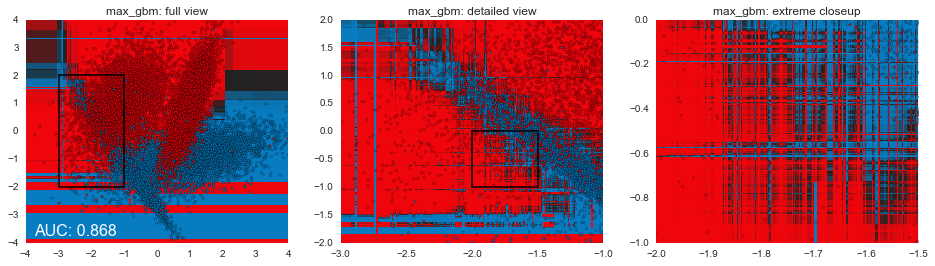

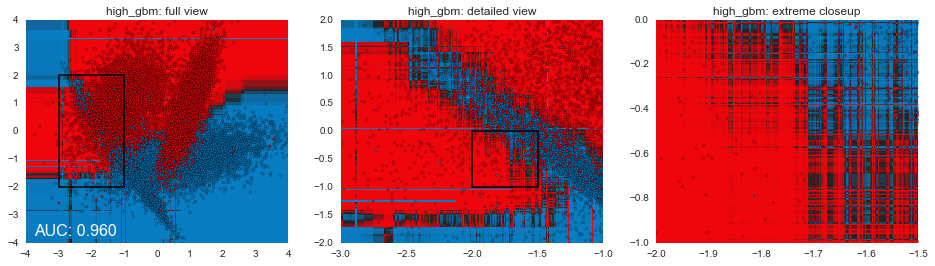

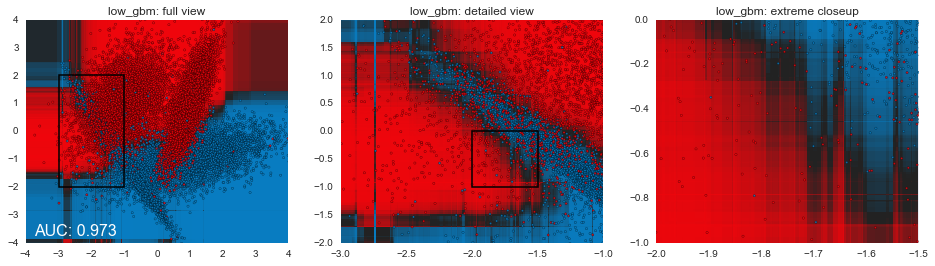

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

common_args = {'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9, 'random_state': 2}

models = [('max_gbm', GradientBoostingClassifier(learning_rate=1, **common_args)),
          ('high_gbm', GradientBoostingClassifier(learning_rate=0.5, **common_args)),
          ('low_gbm', GradientBoostingClassifier(learning_rate=0.05, **common_args))]

preds = fit_models(models)
for mname, model in models:
    three_plots(mname, model)
rocs.update({mname: roc_auc_score(test_t, p['test'][:,1]) for mname, p in preds.iteritems()})

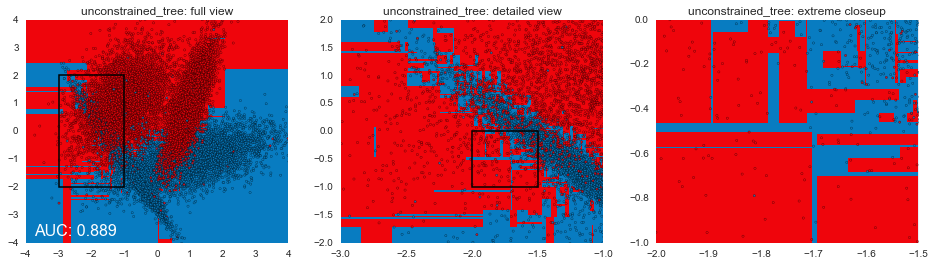

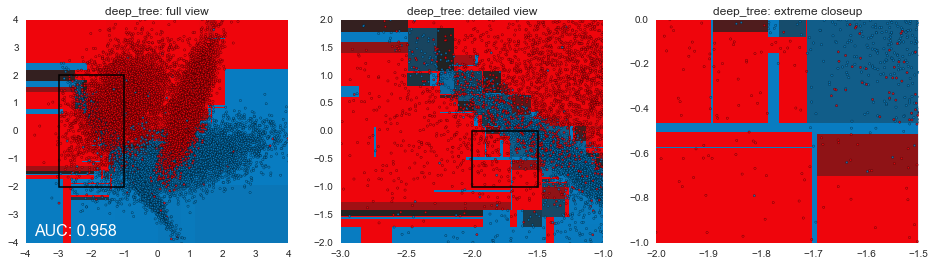

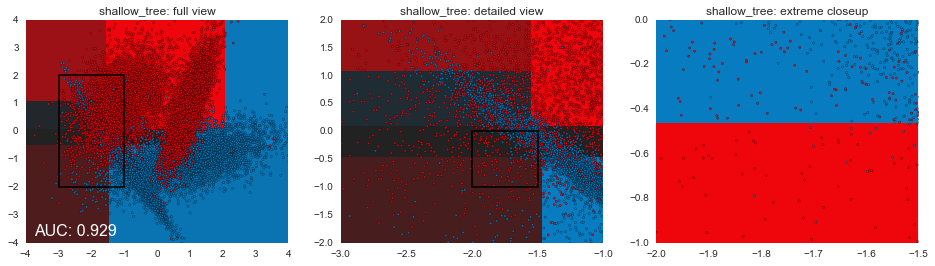

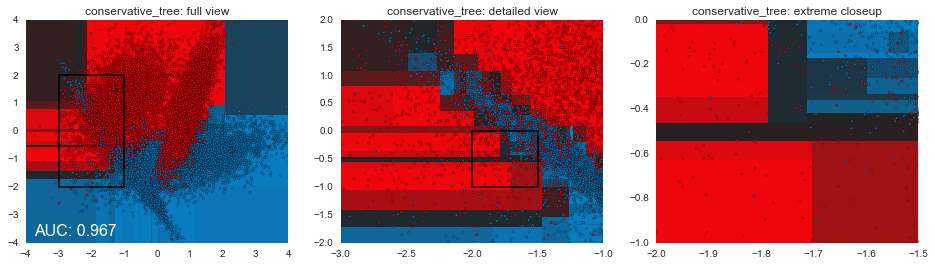

In [75]:
from sklearn.tree import DecisionTreeClassifier

my_cm = sns.diverging_palette(h_neg=245, h_pos=12, s=99, l=50, sep=15, n=32, center='dark', as_cmap=True)

models = [('unconstrained_tree', DecisionTreeClassifier(max_depth=None)),
          ('deep_tree', DecisionTreeClassifier(max_depth=9)),
          ('shallow_tree', DecisionTreeClassifier(max_depth=3)),
          ('conservative_tree', DecisionTreeClassifier(min_samples_leaf=20))]

preds = fit_models(models)
for mname, model in models:
    three_plots(mname, model)
rocs.update({mname: roc_auc_score(test_t, p['test'][:,1]) for mname, p in preds.iteritems()})

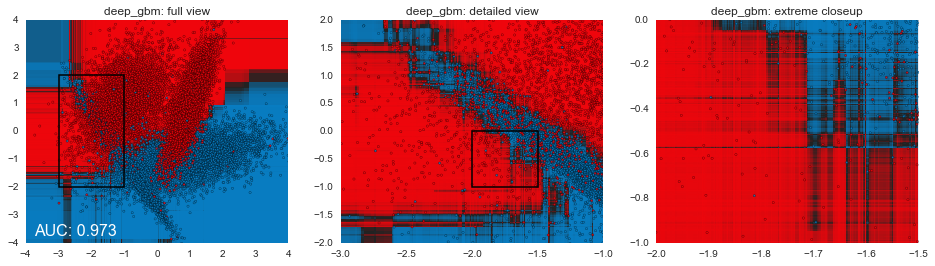

KeyboardInterrupt: 

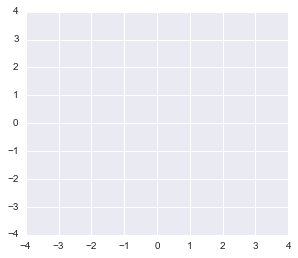

In [76]:
from sklearn.ensemble import RandomForestClassifier

gbm_args = {'learning_rate': 0.05, 'n_estimators': 500, 'subsample': 0.9, 'random_state': 2}
rf_args = {'n_estimators': 200, 'random_state': 2}

models = [('deep_gbm', GradientBoostingClassifier(max_depth=7, **gbm_args)),
          ('deep_rf', RandomForestClassifier(max_depth=7, **rf_args)),
          
          ('shallow_gbm', GradientBoostingClassifier(max_depth=3, **gbm_args)),
          ('shallow_rf', RandomForestClassifier(max_depth=3, **rf_args)),

          ('conservative_gbm', GradientBoostingClassifier(min_samples_leaf=20, **gbm_args)),
          ('conservative_rf', RandomForestClassifier(min_samples_leaf=20, **rf_args))]
          
preds = fit_models(models)
for mname, model in models:
    three_plots(mname, model)
rocs.update({mname: roc_auc_score(test_t, p['test'][:,1]) for mname, p in preds.iteritems()})

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = [('logistic', LogisticRegression(random_state=2)),
          ('knn', KNeighborsClassifier(n_neighbors=13)),
          ('svc', SVC(tol=1, probability=True, random_state=2))]

preds = fit_models(models)
for mname, model in models:
    three_plots(mname, model)
rocs.update({mname: roc_auc_score(test_t, p['test'][:,1]) for mname, p in preds.iteritems()})

In [20]:
print '\n'.join('%20s: %.4f' % (m, r) for m, r in sorted(rocs.items(), key=lambda x: x[1], reverse=True))

    conservative_gbm: 0.9728
            deep_gbm: 0.9726
     conservative_rf: 0.9725
         shallow_gbm: 0.9725
             low_gbm: 0.9725
                 knn: 0.9701
             deep_rf: 0.9697
   conservative_tree: 0.9668
                 svc: 0.9605
            high_gbm: 0.9603
           deep_tree: 0.9586
          shallow_rf: 0.9486
        shallow_tree: 0.9289
            logistic: 0.9217
  unconstrained_tree: 0.8886
             max_gbm: 0.8682


In [21]:
from itertools import product
mnames = map("_".join, product(("conservative", "shallow", "deep"), ("rf", "gbm")))
print '\n'.join('%20s: %.4f' % (m, rocs[m]) for m in mnames)

     conservative_rf: 0.9725
    conservative_gbm: 0.9728
          shallow_rf: 0.9486
         shallow_gbm: 0.9725
             deep_rf: 0.9697
            deep_gbm: 0.9726
